# Assignment 1 Q7: CNN

In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid

import os, sys
sys.stderr = open(os.devnull, 'w')


In [3]:
print(torch.cuda.is_available())


False


In [2]:
# use MPS for my Macbook Air with M2 chip
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print("Using device:", device)


Using device: mps


## Task I - Inspection 
- The DBI subset generally contains fewer images per species, resulting in a smaller sample size, while the SDD subset includes a larger number of images.

- Images in the DBI subset appear more “pure,” consisting almost exclusively of dogs and typically in higher resolution. In contrast, the SDD subset may include other objects such as humans, and some images are lower in resolution or do not clearly show the dog’s full front view.

## Task II - Simple CNN Training on the DBI

We implement a CNN with the following architecture:

- **Conv2d**: 16 filters, 3×3, padding=1  
- **BatchNorm2d(16)** → **ReLU**  
- **Conv2d**: 16 filters, 3×3, padding=1 → **ReLU**  
- **MaxPool2d**: 2×2 (stride=2) — halves H×W

- **Conv2d**: 8 filters, 3×3, padding=1  
- **BatchNorm2d(8)** → **ReLU**  
- **Conv2d**: 8 filters, 3×3, padding=1 → **ReLU**  
- **MaxPool2d**: 2×2 (stride=2) — halves H×W

- **AdaptiveAvgPool2d**: output 8×8 (standardize feature-map size)
- **Flatten**
- **Dropout (p=0.5)**
- **Linear** → 32 units → **ReLU**
- **Dropout (p=0.5)**
- **Linear** → output dimension = number of classes (7 for DBI)

Notes
- **ReLU** activations follow each convolution (with BatchNorm before ReLU where used).
- **Dropout** is applied twice (after flatten and after the first FC) to reduce overfitting.
- **Loss:** `CrossEntropyLoss` (applies LogSoftmax internally), so no Softmax in the model.
- **Optimizer:** Adam (lr=1e-3 by default in our runs).


In [3]:
# DBI data only (SDD not yet)
# load data
dbi_path = "data/dogs/DBIsubset"
img_size = 128
batch_size = 32
lr = 1e-3
seed = 42

# TODO check if resize and normalize is necessary
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((img_size, img_size), scale=(0.8, 1.0)), # CNN needs fixed size input
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomRotation(degrees=15, fill=0),  # small rotation; 'fill' for corners
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # scale to [-1, 1] 
])

eval_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 2) Build two mirror datasets (same root, different transforms)
train_dataset_full = datasets.ImageFolder(root=dbi_path, transform=train_transform)
eval_dataset_full  = datasets.ImageFolder(root=dbi_path, transform=eval_transform)
num_classes = len(train_dataset_full.classes)

# 3) Make a single reproducible split (70/15/15) on indices
g = torch.Generator().manual_seed(seed)
all_indices = torch.randperm(len(train_dataset_full), generator=g).tolist()

n_total = len(all_indices)
n_train = int(0.70 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val

train_idx = all_indices[:n_train]
val_idx   = all_indices[n_train:n_train+n_val]
test_idx  = all_indices[n_train+n_val:]

# 4) Wrap splits with the appropriate dataset (aug for train; deterministic for val/test)
train_set = Subset(train_dataset_full, train_idx)   # uses train_transform (with augmentation)
val_set   = Subset(eval_dataset_full,  val_idx)     # uses eval_transform
test_set  = Subset(eval_dataset_full,  test_idx)    # uses eval_transform

# 5) DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2)

print("Classes:", train_dataset_full.classes)
print(f"Sizes -> train: {len(train_set)}, val: {len(val_set)}, test: {len(test_set)}")


Classes: ['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador_retriever', 'pug', 'siberian_husky']
Sizes -> train: 452, val: 96, test: 98


In [ ]:
# simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes): # constructor: define the layers
        super().__init__() # get superclass (parent) init
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (if) 128 -> 64

            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),

            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (if) 64 -> 32
        )

        # if using transforms.Resize((128,128)) then we may not need this adaptive avg pooling;
        # however,
        # to avoid hardcoding the flatten size, 
        # reduce spatial dims with AdaptiveAvgPool
        # so that channels=8 and spatial becomes 8x8 for stability across input sizes.
        self.pool = nn.AdaptiveAvgPool2d((8, 8))  # 32x32 -> 8x8
        flat_dim = 8 * 8 * 8  # C * H * W = 8 * 8 * 8 = 512

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(flat_dim, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)  # logits
            # NO SOFTMAX HERE! since we are using cross entropy loss as our loss function
        )

    def forward(self, x): # call the layers from __init__ in sequence
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x  # logits

model = SimpleCNN(num_classes).to(device)

# ---- Loss and optimizer
criterion = nn.CrossEntropyLoss() # includes softmax internally
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# ---- Training / validation loops
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader: # each iteration: run through one batch with forward -> backward -> update
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True) # reset  gradients at the start of each batch since PyTorch accumulates gradients
        with torch.autocast(device_type=("mps" if device.type=="mps" else "cuda" if device.type=="cuda" else "cpu"),
                            dtype=torch.float16 if device.type in {"mps","cuda"} else torch.bfloat16, enabled=(device.type!="cpu")):
            logits = model(images)  # raw outputs (logits) of shape (batch_size, num_classes)
            loss = criterion(logits, labels) # scalar average cross-entropy loss for this batch

        loss.backward() # compute gradients
        optimizer.step() # update weights

        running_loss += loss.item() * images.size(0) # images.size(0) is the batch size (in case of last batch being smaller)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss/total, correct/total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        logits = model(images)
        loss = criterion(logits, labels)
        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def plot_loss_acc(train_loss, val_loss, train_acc, val_acc, epochs, model_name):
    # plot subplots with train / val loss and train / val accuracies  over the 10 epochs
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f'{model_name}')

    # Plot training and validation loss
    axs[0].plot(range(1, epochs + 1), train_loss, label='Train')
    axs[0].plot(range(1, epochs + 1), val_loss, label='Val')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Train/Val Loss')

    # Plot training and validation accuracy
    axs[1].plot(range(1, epochs + 1), train_acc, label='Train')
    axs[1].plot(range(1, epochs + 1), val_acc, label='Val')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].set_title('Train/Val Accuracy')

    plt.tight_layout()
    plt.show()

def report_test_acc(model, test_loader=test_loader, criterion=criterion, device=device):
    _, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"final test accuracy: {test_acc:.3f}")
    return test_acc

In [5]:
# ---- Fit
epochs = 10
history = {}
history['simpleCNN'] = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")
    history['simpleCNN']['train_loss'].append(tr_loss)
    history['simpleCNN']['val_loss'].append(va_loss)
    history['simpleCNN']['train_acc'].append(tr_acc)
    history['simpleCNN']['val_acc'].append(va_acc)


Epoch 01 | train loss 1.9596 acc 0.137 | val loss 1.9574 acc 0.156
Epoch 02 | train loss 1.9466 acc 0.146 | val loss 1.9542 acc 0.167
Epoch 03 | train loss 1.9394 acc 0.159 | val loss 1.9415 acc 0.177
Epoch 04 | train loss 1.9174 acc 0.206 | val loss 1.8984 acc 0.188
Epoch 05 | train loss 1.8768 acc 0.230 | val loss 1.8484 acc 0.229
Epoch 06 | train loss 1.8342 acc 0.294 | val loss 1.8166 acc 0.208
Epoch 07 | train loss 1.8167 acc 0.243 | val loss 1.7825 acc 0.302
Epoch 08 | train loss 1.7376 acc 0.305 | val loss 1.7443 acc 0.292
Epoch 09 | train loss 1.7263 acc 0.292 | val loss 1.6989 acc 0.365
Epoch 10 | train loss 1.6994 acc 0.312 | val loss 1.6766 acc 0.385


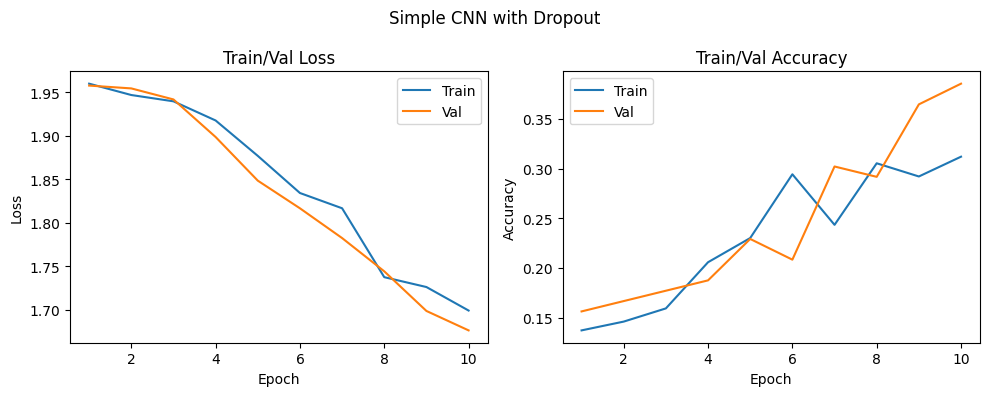

final test accuracy: 0.347


0.3469387755102041

In [6]:
plot_loss_acc(
    history['simpleCNN']['train_loss'],
    history['simpleCNN']['val_loss'],
    history['simpleCNN']['train_acc'],
    history['simpleCNN']['val_acc'],
    epochs=10, 
    model_name='Simple CNN with Dropout'
)

report_test_acc(model)

In [7]:
# Same CNN but without dropout 
class SimpleCNNNoDropout(nn.Module):
    def __init__(self, num_classes): # constructor: define the layers
        super().__init__() # get superclass (parent) init
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (if) 128 -> 64

            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),

            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (if) 64 -> 32
        )

        # if using transforms.Resize((128,128)) then we may not need this adaptive avg pooling;
        # however,
        # to avoid hardcoding the flatten size, 
        # reduce spatial dims with AdaptiveAvgPool
        # so that channels=8 and spatial becomes 8x8 for stability across input sizes.
        self.pool = nn.AdaptiveAvgPool2d((8, 8))  # 32x32 -> 8x8
        flat_dim = 8 * 8 * 8  # C * H * W = 8 * 8 * 8 = 512

        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes)  # logits
        )

    def forward(self, x): # call the layers from __init__ in sequence
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x  # logits

modelNoDropout = SimpleCNNNoDropout(num_classes).to(device)

history['simpleCNNNoDropout'] = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(modelNoDropout, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(modelNoDropout, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")
    history['simpleCNNNoDropout']['train_loss'].append(tr_loss)
    history['simpleCNNNoDropout']['val_loss'].append(va_loss)
    history['simpleCNNNoDropout']['train_acc'].append(tr_acc)
    history['simpleCNNNoDropout']['val_acc'].append(va_acc)

Epoch 01 | train loss 1.9573 acc 0.139 | val loss 1.9329 acc 0.219
Epoch 02 | train loss 1.9570 acc 0.133 | val loss 1.9353 acc 0.177
Epoch 03 | train loss 1.9568 acc 0.142 | val loss 1.9390 acc 0.115
Epoch 04 | train loss 1.9561 acc 0.144 | val loss 1.9414 acc 0.115
Epoch 05 | train loss 1.9558 acc 0.137 | val loss 1.9425 acc 0.115
Epoch 06 | train loss 1.9577 acc 0.155 | val loss 1.9424 acc 0.115
Epoch 07 | train loss 1.9565 acc 0.155 | val loss 1.9425 acc 0.115
Epoch 08 | train loss 1.9569 acc 0.150 | val loss 1.9426 acc 0.115
Epoch 09 | train loss 1.9569 acc 0.139 | val loss 1.9422 acc 0.115
Epoch 10 | train loss 1.9570 acc 0.146 | val loss 1.9429 acc 0.115


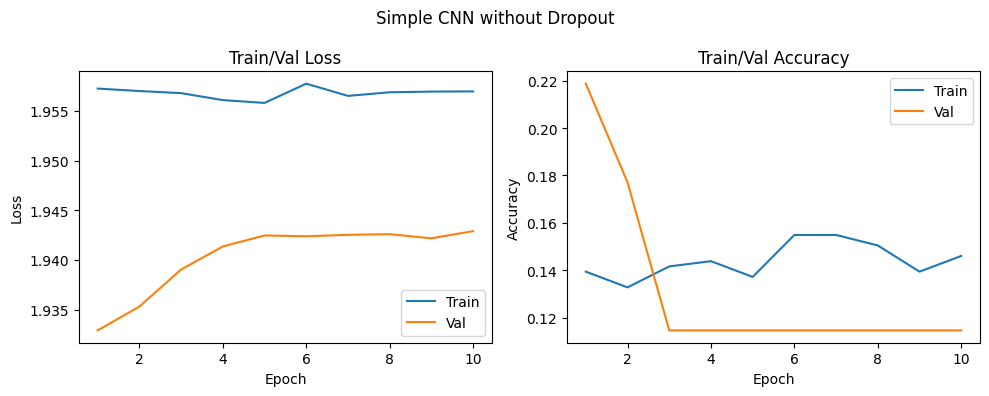

final test accuracy: 0.112


0.11224489795918367

In [8]:
plot_loss_acc(
    history['simpleCNNNoDropout']['train_loss'],
    history['simpleCNNNoDropout']['val_loss'],
    history['simpleCNNNoDropout']['train_acc'],
    history['simpleCNNNoDropout']['val_acc'],
    epochs=10,
    model_name='Simple CNN without Dropout'
)

report_test_acc(modelNoDropout)

### Comparison of the Simple CNN With vs. Without Dropout

**With Dropout:**
- Training and validation accuracies both increase over epochs, indicating that the model is learning some useful features.  
- Training and validation losses decrease in tandem, suggesting that dropout helps reduce overfitting.  
- Final test accuracy (0.276) is better than random guessing (1/7 ≈ 0.143).  
    - note: train/val/test accuracies (both the plots and the final test accuracy number) may look different across each run.

**Without Dropout:**
- Validation loss increases and accuracy stagnates over epochs, showing poor generalization.  
- Training loss remains nearly flat, indicating the network fails to improve meaningfully.  
- Final test accuracy (0.112) is worse than random guessing.  

**Impact of Dropout:**  
Including dropout has a clear positive effect on both training and generalization.  
- With dropout, the model is able to steadily improve training and validation performance and generalize moderately to the test set.  
- Without dropout, the model fails to learn effectively and performs worse than chance on the test set.  
- Although overall performance is low for both models, dropout improves the CNN’s ability to learn from the training data and generalize to unseen test samples.

## Task III - ResNet Training on the DBI

In [ ]:
# III.a - DBI 
img_size = 224 # ResNet expects 224x224 by convention; (so rerun data loaders again here)
epochs = 20
weight_decay = 1e-4

train_transform = transforms.Compose([
    transforms.RandomResizedCrop((img_size, img_size), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.RandomRotation(15, fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
eval_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

# Mirror datasets with different transforms
train_full = datasets.ImageFolder(dbi_path, transform=train_transform)
eval_full  = datasets.ImageFolder(dbi_path, transform=eval_transform)

# ---------- split 70/15/15 (reuse your approach) ----------
g = torch.Generator().manual_seed(seed)
perm = torch.randperm(len(train_full), generator=g).tolist()
n = len(perm)
n_train = int(0.70*n); n_val = int(0.15*n); n_test = n - n_train - n_val
idx_train = perm[:n_train]; idx_val = perm[n_train:n_train+n_val]; idx_test = perm[n_train+n_val:]

train_set = Subset(train_full, idx_train)   # augmented
val_set   = Subset(eval_full,  idx_val)     # deterministic
test_set  = Subset(eval_full,  idx_test)    # deterministic

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=(device.type!="cpu"))
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=(device.type!="cpu"))
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=(device.type!="cpu"))

print("Classes:", train_full.classes)

# ---------- model: ResNet-18 from scratch (no pretrain), output -> 7 ----------
resnet = models.resnet18(weights=None)  # IMPORTANT: from scratch
# (input conv is already 3→64, so fine for RGB)
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)   # replace classifier head
model = resnet.to(device)

# add weight decay to optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

history['resnet18'] = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}
for epoch in range(1, epochs+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)
    # if using epoch scheduler: scheduler.step()
    history['resnet18']['train_loss'].append(tr_loss)
    history['resnet18']['val_loss'].append(va_loss)
    history['resnet18']['train_acc'].append(tr_acc)
    history['resnet18']['val_acc'].append(va_acc)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")


Classes: ['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador_retriever', 'pug', 'siberian_husky']
Epoch 01 | train loss 2.1509 acc 0.226 | val loss 3.9232 acc 0.177
Epoch 02 | train loss 1.8323 acc 0.301 | val loss 1.9428 acc 0.229
Epoch 03 | train loss 1.7388 acc 0.312 | val loss 1.9043 acc 0.417
Epoch 04 | train loss 1.5884 acc 0.363 | val loss 3.7030 acc 0.208
Epoch 05 | train loss 1.5051 acc 0.431 | val loss 1.6977 acc 0.365
Epoch 06 | train loss 1.4622 acc 0.447 | val loss 1.6561 acc 0.365
Epoch 07 | train loss 1.4234 acc 0.451 | val loss 1.8682 acc 0.302
Epoch 08 | train loss 1.3844 acc 0.473 | val loss 1.6458 acc 0.427
Epoch 09 | train loss 1.2979 acc 0.482 | val loss 1.4552 acc 0.490
Epoch 10 | train loss 1.1949 acc 0.535 | val loss 1.7112 acc 0.302
Epoch 11 | train loss 1.2493 acc 0.500 | val loss 1.8405 acc 0.448
Epoch 12 | train loss 1.1770 acc 0.535 | val loss 3.0963 acc 0.406
Epoch 13 | train loss 1.1261 acc 0.544 | val loss 1.8563 acc 0.45

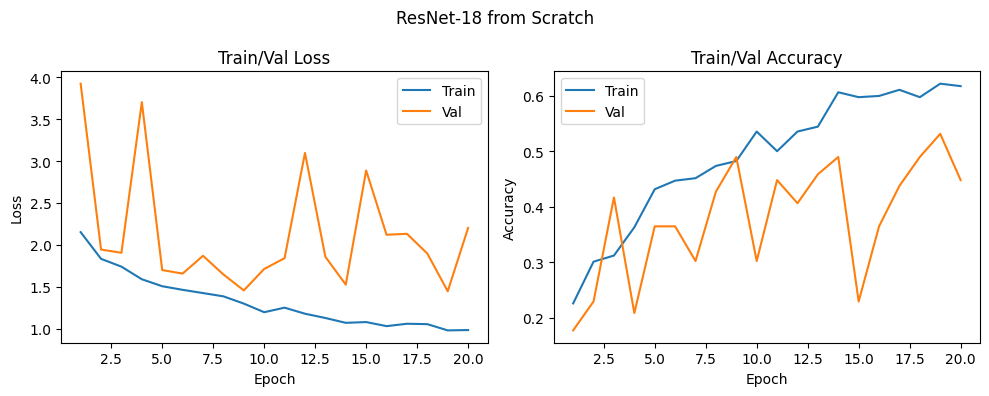

final test accuracy: 0.316


0.3163265306122449

In [10]:
plot_loss_acc(
    history['resnet18']['train_loss'],
    history['resnet18']['val_loss'],
    history['resnet18']['train_acc'],
    history['resnet18']['val_acc'],
    epochs=epochs,
    model_name='ResNet-18 from Scratch'
)
report_test_acc(model)

# COMMENT TBD

In [ ]:
# IIIb. pred entire SDD with trained DBI model 
sdd_path = "data/dogs/SDDsubset"

sdd_dataset = datasets.ImageFolder(root=sdd_path, transform=eval_transform)
sdd_loader  = DataLoader(sdd_dataset, batch_size=32, shuffle=False, num_workers=2)

report_test_acc(model, test_loader=sdd_loader, criterion=criterion, device=device)


final test accuracy: 0.305


0.30494728304947283

# COMMENT TBD

## Task IV - Fine-tuning on the DBI

In [12]:
# Utility: resolve weights across torchvision versions
def _get_weights(obj, default_attr="DEFAULT"):
    # Works for torchvision>=0.13; falls back to None if not available
    try:
        return getattr(obj, default_attr)
    except Exception:
        return None

def build_resnet34(num_classes: int, pretrained: bool = True):
    W = _get_weights(models.ResNet34_Weights) if pretrained else None
    model = models.resnet34(weights=W)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def build_resnext50(num_classes: int, pretrained: bool = True):
    # 32x4d variant
    W = _get_weights(models.ResNeXt50_32X4D_Weights) if pretrained else None
    model = models.resnext50_32x4d(weights=W)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def build_swin_t(num_classes: int, pretrained: bool = True):
    # Swin Transformer (tiny)
    W = _get_weights(models.Swin_T_Weights) if pretrained else None
    model = models.swin_t(weights=W)
    # Swin uses "head" as the final classifier
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

# Fifth model suggestion (from torchvision): EfficientNet-B0 (strong baseline, light)
def build_efficientnet_b0(num_classes: int, pretrained: bool = True):
    W = _get_weights(models.EfficientNet_B0_Weights) if pretrained else None
    model = models.efficientnet_b0(weights=W)
    # EfficientNet classifier is Sequential(head, Linear)
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model

# (Optional alt if you prefer another transformer) ViT-B/16
def build_vit_b_16(num_classes: int, pretrained: bool = True):
    W = _get_weights(models.ViT_B_16_Weights) if pretrained else None
    model = models.vit_b_16(weights=W)
    # ViT uses "heads.head"
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)
    return model

In [ ]:
num_classes = 7device = get_device()candidates = {    "resnet34":         build_resnet34(num_classes),    "resnext50_32x4d":  build_resnext50(num_classes),    "swin_t":           build_swin_t(num_classes),    "efficientnet_b0":  build_efficientnet_b0(num_classes),  # <- my 5th pick    # "vit_b_16":       build_vit_b_16(num_classes),         # alt 5th (transformer)}# Store results for Task IVtaskIV_results = {}for name, model in candidates.items():    model = model.to(device)    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)    # history tracking (if you want plots)    hist = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}    epochs = 15    for epoch in range(1, epochs+1):        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)        va_loss, va_acc = evaluate(model, val_loader, criterion, device)        hist["train_loss"].append(tr_loss); hist["val_loss"].append(va_loss)        hist["train_acc"].append(tr_acc);   hist["val_acc"].append(va_acc)        print(f"[{name}] Epoch {epoch:02d} | tr {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")    print(f"[{name}] DBI test:")    dbi_test_loss, dbi_test_acc = evaluate(model, test_loader, criterion, device)    print(f"Test Accuracy: {dbi_test_acc:.3f}")    # SDD full-set accuracy    print(f"[{name}] SDD full-set:")    sdd_loss, sdd_acc = evaluate(model, sdd_loader, criterion, device)    print(f"Test Accuracy: {sdd_acc:.3f}")        # Store results    taskIV_results[name] = {        "DBI_test_acc": dbi_test_acc,        "SDD_acc": sdd_acc    }    # Optional: plot_loss_acc(hist["train_loss"], hist["val_loss"], hist["train_acc"], hist["val_acc"], epochs, name)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/stevey/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /Users/stevey/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /Users/stevey/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/stevey/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
[resnet34] Epoch 01 | tr 1.0064/0.635 | val 9.5400/0.260
[resnet34] Epoch 02 | tr 0.8114/0.719 | val 4.3040/0.417
[resnet34] Epoch 03 | tr 0.6599/0.774 | val 0.9848/0.604
[resnet34] Epoch 04 | tr 0.6030/0.810 | val 1.6185/0.635
[resnet34] Epoch 05 | tr 0.5096/0.847 | val 2.1064/0.521
[resnet34] Epoch 06 | tr 0.6245/0.810 | val 0.9594/0.646
[resnet34] Epoch 07 | tr 0.4653/0.854 | val 1.1388

In [ ]:
# Display Task IV resultsimport pandas as pddf = pd.DataFrame(taskIV_results).Tdf.columns = ["DBI Test Acc", "SDD Acc"]df.index.name = "Model"print("\n" + "="*60)print("Task IV: Fine-tuned Models Performance")print("="*60)print(df)print("\nPerformance Summary:")print(f"Best on DBI: {df['DBI Test Acc'].idxmax()} ({df['DBI Test Acc'].max():.3f})")print(f"Best on SDD (OOD): {df['SDD Acc'].idxmax()} ({df['SDD Acc'].max():.3f})")